In [1]:
from transformers import PreTrainedModel, LlamaConfig, LlamaModel, LlamaTokenizer
import torch.nn as nn
import torch
from typing import Optional, List
from rlhfutils.data import load_ultra
import seaborn as sns
from datasets import Dataset, load_dataset
from IPython.core.display import display, HTML

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-11-06 07:36:04,139] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/tmp/ipykernel_2296198/2092234368.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
class LlamaRewardModel(PreTrainedModel):
    config_class = LlamaConfig
    def __init__(self, config):
        super().__init__(config)
        self.model = LlamaModel(config)
        self.regression_head = nn.Linear(self.config.hidden_size, 1, bias=False)

    def forward( # args are the same as LlamaForCausalLM
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):

        transformer_outputs = self.model(
                                input_ids,
                                attention_mask=attention_mask,
                                position_ids=position_ids,
                                past_key_values=past_key_values,
                                inputs_embeds=inputs_embeds,                               
                            )

        hidden_states = transformer_outputs[0]
        rewards = self.regression_head(hidden_states).squeeze(-1)
        
        ends = attention_mask.cumsum(dim=1).argmax(dim=1).view(-1,1)
        rewards = torch.gather(rewards, 1, ends)
        
        return rewards

ultrarm_template = """Human: {instruction}

Assistant: {completion}"""

dataset = [ # cases in webgpt
  {"chosen":"Human: \"Who orders martinis \"\"shaken, not stirred\"\"?\"\nAssistant: Sean Connery's character, fictional British Secret Service agent James Bond, in the movie Goldfinger, stated that he preferred his martini to be \"shaken, not stirred\". [1] Some believe that Bond ordered his martini shaken because of the vodka it contained, as vodka was, for the most part, refined from potatoes (cheaper brands) which made the vodka oily. To disperse the oil, Bond ordered his martinis shaken. [2]","rejected":"Human: \"Who orders martinis \"\"shaken, not stirred\"\"?\"\nAssistant: Fleming's fictional British Secret Service agent James Bond orders his martini cocktail shaken, not stirred [1]. Bond's preferences for his martini are carried over to the films, where his orders are seen in both the 1961 film Dr. No and the 2006 film Casino Royale [1, 2]. In both films, Bond's subordinates copy his order, telling the bartender to keep the fruit with their drinks [2]. However, in the 2006 film, Bond appears irritated when the bartender asks if he would like his drink shaken or stirred [2]."},
  {"chosen":"Human: Sural relates to which part of the body?\nAssistant: The sural region is the muscular swelling of the back of the leg below the knee, formed chiefly by the bellies of the gastrocnemius and soleus muscles [1,2].","rejected":"Human: Sural relates to which part of the body?\nAssistant: The Sural nerve runs down the side of the leg near the small saphenous vein, then passes forward below the lateral malleolus and continues on the outside of the foot as the lateral dorsal cutaneous nerve, which then communicates with the intermediate dorsal cutaneous nerve, which branches off to the side of the foot. [1]"}
]

In [4]:
ultrarm_template.format(instruction="yo", completion= "yo")

'Human: yo\n\nAssistant: yo'

In [4]:
tokenizer = LlamaTokenizer.from_pretrained("openbmb/UltraRM-13b")
model = LlamaRewardModel.from_pretrained("openbmb/UltraRM-13b", torch_dtype=torch.bfloat16, device_map=0)
model.eval()

Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:26<00:00, 28.89s/it]
Some weights of LlamaRewardModel were not initialized from the model checkpoint at openbmb/UltraRM-13b and are newly initialized: ['model.layers.30.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.rotary_emb.inv_freq', 'model.layers.24.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.32.self_attn.rotary_emb.inv_freq', 'model.layers.26.self_attn.rotary_emb.inv_freq', 'model.layers.22.self_attn.rotary_emb.inv_freq', 'model.layers.29.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.33.self_attn.rotary_emb.inv_freq', 'model.layers.31.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'm

LlamaRewardModel(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

In [6]:
torch.cuda.empty_cache()

In [25]:

# code for generating text in annotation format for us to use
def print_example(ind, rinds, showrats=True):
    print("*************** EXAMPLE", ind , ": ***************")
    question_color = "#4287f5"  # blue
    bar_color = "#2bc235" # green
    rating_color = "#fc3819" # red
    lsplit = "__________________ <br> __________________ <br> __________________ <br>"
    row = data['train'][ind]
    print("QUESTION\n___________________")
    s = row['instruction'].replace("\n", "<br>")
    display(HTML(f'<span style="color: {question_color}">{s}</span>'))
    
    display(HTML(f'<span style="color: {bar_color}">{lsplit}</span>'))
    print("RESPONSE 1: ")
    c1 = row['completions'][rinds[0]]
    print(c1['response'])

    if showrats:
        display(HTML(f'<span style="color: {bar_color}">{lsplit}</span>'))
        # compute RM score
        resp = ultrarm_template.format(instruction=row['instruction'], completion=c1['response'])
        inputs = tokenizer(resp, return_tensors="pt").to(model.device)
        chosen_reward = model(**inputs).item()

        print("RM SCORE : ", chosen_reward)
        print("MODEL : ", c1['model'])
        rs = "ANNOTATIONS<br>"
        for an in c1['annotations'].keys():
            annot = c1['annotations'][an]
            rs = rs+an+ " : "+ annot['Rating']+ " : "+ annot['Rationale']+"<br>"
        rs = rs+"CRITIQUE: "+c1['critique']
        display(HTML(f'<span style="color: {rating_color}">{rs}</span>'))
        
    display(HTML(f'<span style="color: {bar_color}">{lsplit}</span>'))
    print("RESPONSE 2:")
    
    c1 = row['completions'][rinds[1]]
    print(c1['response'])
    if showrats:
        display(HTML(f'<span style="color: {bar_color}">{lsplit}</span>'))
        
        # compute RM score
        resp = ultrarm_template.format(instruction=row['instruction'], completion=c1['response'])
        inputs = tokenizer(resp, return_tensors="pt").to(model.device)
        chosen_reward = model(**inputs).item()

        print("RM SCORE : ", chosen_reward)
        print("MODEL : ", c1['model'])
        rs = "ANNOTATIONS<br>"
        for an in c1['annotations'].keys():
            annot = c1['annotations'][an]
            rs = rs+an+ " : "+ annot['Rating']+ " : "+ annot['Rationale']+"<br>"
        rs = rs+"CRITIQUE: "+c1['critique']
        display(HTML(f'<span style="color: {rating_color}">{rs}</span>'))
    # print(row['completions'][rinds[0]].keys())

In [11]:
print(data['train'][0]['completions'][0].keys())

dict_keys(['annotations', 'custom_system_prompt', 'model', 'principle', 'response', 'critique', 'overall_score'])


In [8]:
# load in dataset
data = load_dataset("openbmb/UltraFeedback")

Found cached dataset json (/u/prasanns/.cache/huggingface/datasets/openbmb___json/openbmb--UltraFeedback-8d3a36e039200bd1/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 227.49it/s]


In [16]:
data = data.shuffle(seed=100)

In [ ]:
for i in range(100, 200):
    print(data['train']['instruction'][i])
    print("******")

In [ ]:
# gpt-4 annotation answer key
for i in range(0,25):
    with torch.no_grad():
        print_example(i, [0,1], False)

In [10]:
correct = 0
tot = 0
diffs = []
with torch.no_grad():
    for example in eval:
        tot = tot + 1
        inputs = tokenizer(example["response_j"], return_tensors="pt").to(model.device)
        chosen_reward = model(**inputs).item()
        inputs = tokenizer(example["response_k"], return_tensors="pt").to(model.device)
        rejected_reward = model(**inputs).item()
        if chosen_reward - rejected_reward > 0:
            correct = correct + 1
        print(tot, " ", chosen_reward - rejected_reward)
        diffs.append(chosen_reward - rejected_reward)

# Output 1: 2.4158712085336447
# Output 2: 0.1896953582763672

1   5.1328125
2   3.4375
3   4.28125
4   10.25
5   12.71875
6   0.6875
7   -0.6875
8   4.15625
9   -1.5
10   5.53125
11   4.0
12   3.4296875
13   4.640625
14   5.59375
15   -0.20703125
16   -1.328125
17   0.1875
18   6.72265625
19   6.1796875
20   -3.283203125
21   1.1875
22   3.5625
23   9.203125
24   11.96875
25   8.8984375
26   1.5625
27   4.3515625
28   -1.21875
29   5.4541015625
30   2.26953125
31   2.9296875
32   4.578125
33   -6.3203125
34   3.84375
35   5.41796875
36   2.5625
37   9.765625
38   -1.46875
39   -4.3125
40   2.31640625
41   2.75
42   -1.609375
43   0.5625
44   1.583984375
45   9.890625
46   -0.515625
47   -3.25
48   0.3125
49   6.5
50   2.40234375
51   3.921875
52   7.08203125
53   1.25
54   -2.40625
55   0.4375
56   9.375
57   2.59375
58   4.28125
59   1.28125
60   -5.15625
61   0.53125
62   4.71875
63   2.28125
64   0.1328125
65   11.625
66   8.59375
67   3.78125
68   0.5546875
69   4.8125
70   4.265625
71   9.125
72   -2.048828125
73   7.2705078125
74   5.578125

In [8]:
train, eval = load_ultra("../data/ultrafeeddiff/")

Loading cached shuffled indices for dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultrafeeddiff/cache-3c77a68b828b795c.arrow


initial size  340025
336624
eval len
3401


In [15]:
edf = pd.DataFrame(eval)

In [14]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
edf['rdff'] = diffs

In [22]:
len(edf[edf['rdff']>0])/len(edf)

0.7841811231990591

In [27]:
pearsonr(list(edf['rdff']), list(edf['tokj']-edf['tok']))

PearsonRResult(statistic=0.39632024328494403, pvalue=2.632739915325759e-128)

(array([  1.,   2.,   0.,   2.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   4.,   2.,   6.,  15.,  29.,  51.,
         86., 143., 214., 304., 365., 427., 383., 371., 266., 216., 190.,
        111.,  76.,  55.,  33.,  21.,   9.,   4.,   7.,   0.,   0.,   1.,
          2.,   0.,   0.,   0.,   0.,   2.]),
 array([-24.9375  , -23.963125, -22.98875 , -22.014375, -21.04    ,
        -20.065625, -19.09125 , -18.116875, -17.1425  , -16.168125,
        -15.19375 , -14.219375, -13.245   , -12.270625, -11.29625 ,
        -10.321875,  -9.3475  ,  -8.373125,  -7.39875 ,  -6.424375,
         -5.45    ,  -4.475625,  -3.50125 ,  -2.526875,  -1.5525  ,
         -0.578125,   0.39625 ,   1.370625,   2.345   ,   3.319375,
          4.29375 ,   5.268125,   6.2425  ,   7.216875,   8.19125 ,
          9.165625,  10.14    ,  11.114375,  12.08875 ,  13.063125,
         14.0375  ,  15.011875,  15.98625 ,  16.960625,  17.935   ,
         18.909375,  19.88375 ,  20.858125,  2

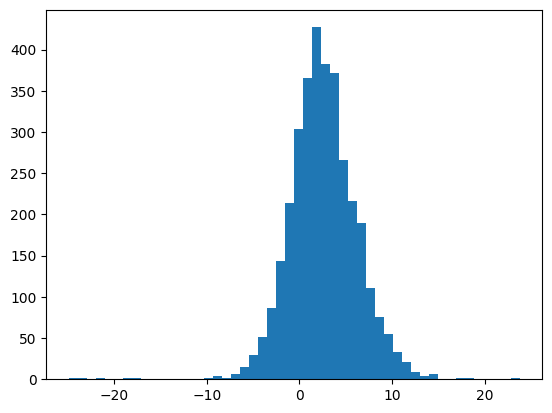

In [19]:
plt.hist(diffs, bins=50)

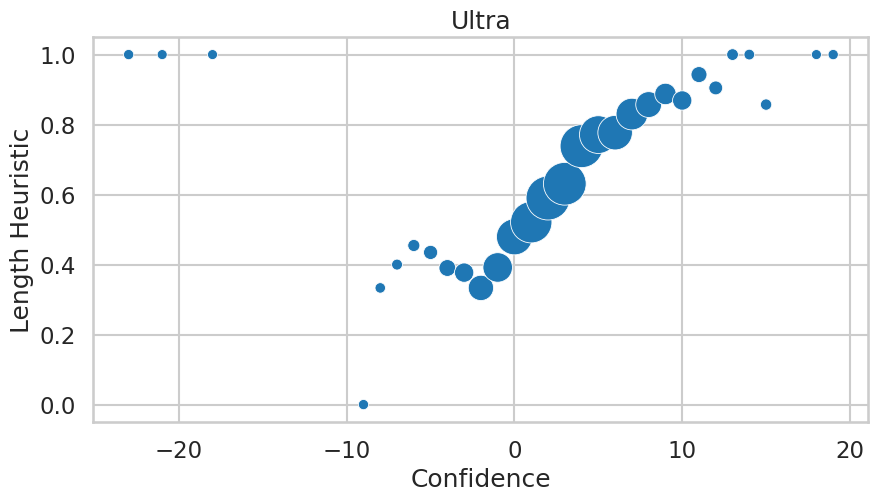

In [36]:
def lenheur(idf):
    return  (idf['tokj']>idf['tok']).mean()
    
def heurscatter(dset, interv, col='rdff'):
    bottom = int(min(dset[col]))
    top = int(max(dset[col]))
    xvals = []
    yvals = []
    dist = []
    for i in range(1, int((top-bottom)/interv)):
        curx = bottom + (interv)*i
        tmpslice = dset.loc[(dset[col]<curx) & (dset[col]>curx-interv)]
        xvals.append(curx)
        yvals.append(lenheur(tmpslice))
        dist.append(len(tmpslice))
    return xvals, yvals, dist
    
def plotscatter(dset, interv, col, title, ax):
    x, y, d = heurscatter(dset, interv, col)
    
    # Scale the d values to use for point size. You can adjust the scaling factor.
    sizes = [val * 10 for val in d]  # adjust the factor (here, 50) as per your data and preferences
    
    sns.scatterplot(x=x, y=y, size=sizes, sizes=(50, 1000), ax=ax, legend=False)
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Length Heuristic')
    ax.set_title(title)

# Setting the style for a prestigious machine learning conference
sns.set_style("whitegrid")
sns.set_context("talk")  # or "paper" or "talk", depends on how big you want things

# Create a figure and axes for the three scatter plots
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Plot each scatter plot on the individual axes
plotscatter(edf, 1, 'rdff', "Ultra", axs)

In [17]:
edf

,question,source,modj,modk,tokj,tok,response_j,response_k,magnitude,__index_level_0__,rdff
0,can you make the following recipe vegan?\n\nIn...,sharegpt,wizardlm-13b,wizardlm-7b,739,55,"To make the recipe vegan, you would need to re...","Yes, the recipe can be made vegan by replacing...",1.750000,234796,5.132812
1,"Detailed Instructions: In this task, based on ...",flan_v2_niv2,llama-2-13b-chat,gpt-3.5-turbo,145,15,Here's my question based on the given input se...,When did Bailey usually volunteer at Indiana P...,0.750000,173705,3.437500
2,"hi, iam going to provide you with a series of ...",sharegpt,gpt-3.5-turbo,alpaca-7b,127,32,Hi! I'd be happy to help you with the Fresh Ea...,"Hello, thank you for providing me with this in...",1.500000,250998,4.281250
3,How would I connect AI or ML API’s to an SQL d...,sharegpt,gpt-3.5-turbo,llama-2-13b-chat,583,375,To connect AI or ML APIs to an SQL database ho...,Hello! I'm here to help you with your question...,1.750000,220654,10.250000
4,아래 책 내용 요약해줘 \n- 제목 : Don't Make Me Think\n- 저...,sharegpt,pythia-12b,mpt-30b-chat,282,240,"""Don't Make Me Think"" is a book written by Ste...","Don't Make Me Think은 홈펠테이션, 웹펠테이션, 지션 에피, 프로그램...",2.000000,223347,12.718750
...,...,...,...,...,...,...,...,...,...,...,...
3396,Can you recommend a good text-to-speech service?,sharegpt,vicuna-33b,alpaca-7b,143,72,"As an AI language model, I am able to provide ...","I would recommend the GWSpeech platform, which...",1.250000,231931,1.984375
3397,Who was \nJoseph Samuels Miller\nB:17 Aug 1848...,sharegpt,vicuna-33b,gpt-4,107,145,"Joseph Samuels Miller was born on August 17, 1...",I am unable to verify the exact history or bio...,0.750000,215779,0.656250
3398,Here's a challenge for you: Design a kitchenwa...,evol_instruct,mpt-30b-chat,ultralm-65b,420,434,Absolutely! Here's a suggestion for a kitchenw...,"Yes, as a top-tier AI assistant, I'm up for th...",0.750000,55032,2.812500
3399,Detailed Instructions: Given a sentence in the...,flan_v2_niv2,gpt-3.5-turbo,llama-2-70b-chat,37,174,"Agad pagkatapos, binisita ng Naval Intelligenc...",Ang libreng interpretasyon ngitori ay napapali...,4.000000,135147,-1.937500


In [16]:
!nvidia-smi

Mon Oct 23 09:52:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   41C    P0    76W / 300W |  45432MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:23:00.0 Off |                    0 |
|  0%   

In [15]:
model.zero_grad()

In [27]:
responses = [
    """Certainly! Here are three niche online communities that cater to specific hobbies or interests:

r/MechanicalKeyboards on Reddit: This community is dedicated to the discussion, design, and use of mechanical keyboards. Members share photos of their customized keyboards, discuss different switch types, give advice on keycap sets, and guide newcomers on building their first mechanical keyboards.

Fountain Pen Network (fountainpennetwork.com): As the name suggests, this online forum is for aficionados of fountain pens. Members discuss various aspects of fountain pen ownership, including reviews, maintenance, inks, and paper. It's a haven for those who appreciate the art of writing with these traditional instruments.

Bonsai Empire (bonsaiempire.com/forum): This community is focused on the art and practice of bonsai, the cultivation of miniaturized trees. Members range from beginners to seasoned experts, and they share tips, techniques, and photos of their bonsai creations.

Each of these communities offers a deep dive into their respective hobbies, allowing enthusiasts to engage, learn, and share their passion with like-minded individuals.
""",

    """Certainly! Niche online communities can be deeply specialized and bring together people with very specific interests. Here are three such communities:

Deskthority: This community is dedicated to mechanical keyboards, key switches, and everything related to typing and input devices. Enthusiasts discuss the different types of keyboards, modifications, historical devices, and even arrange meetups.

Strobist: This community is focused on the art and technique of using off-camera flash in photography. The Strobist blog, started by David Hobby, introduced many photographers to the potential of small, manual flashes used off-camera. The community that has grown around it discusses techniques, equipment recommendations, and creative approaches to lighting.

Fountain Pen Network: This is a hub for fountain pen enthusiasts. Members discuss various brands, types of ink, paper compatibility, and share reviews. There are also sections for calligraphy and pen modifications. It's a place where beginners can get advice and seasoned collectors can discuss rare and vintage finds.

Each of these communities highlights the depth and passion people can have for seemingly specific hobbies or interests.
""",
    """Certainly! Making a triangle out of three sticks is a straightforward process, but it's important to remember that the length of the sticks matters. The sum of the lengths of any two sticks must always be greater than the length of the third stick. This is known as the triangle inequality theorem.

Here's how to make a triangle out of three sticks:

Check the Stick Lengths: Before you start, ensure that the sticks you have satisfy the triangle inequality theorem:

Let's say the sticks are of lengths a, b, and c. Then, the following three conditions should be true:
a+b>c
a+c>b
b+c>a
If any of these conditions aren't met, you cannot form a triangle with those sticks.
Place the First Stick: Lay one stick down on a flat surface.

Position the Second Stick: Take another stick and place one end against an end of the first stick, forming a 'V' shape. Depending on the lengths of your sticks and the type of triangle you're trying to create (e.g., equilateral, isosceles, or scalene), you might adjust the angle between the two sticks.

Attach the Third Stick: Take the third stick and complete the triangle by connecting the free ends of the first and second sticks.

Secure the Triangle (if necessary): If you want the triangle to maintain its shape, you can secure the three corners using a variety of methods:

Use adhesive tape, if you're working with lightweight materials.
Tie them together with string or rubber bands if they have a rougher texture.
Use small clamps if you're working with heavier materials.
If the sticks are meant for crafting, you can use glue or other adhesives to keep the joints together.
Remember, the exact shape and angles of your triangle will depend on the relative lengths of the sticks. If all three sticks are of equal length, you'll get an equilateral triangle. If two sticks are of the same length and the third is different, it'll be an isosceles triangle. If all three sticks have different lengths, you'll have a scalene triangle.
""",
    """Creating a triangle out of three sticks requires a basic understanding of the triangle inequality theorem. The theorem states that the sum of the lengths of any two sides of a triangle must be greater than the length of the third side. This means not any three sticks can form a triangle; they must satisfy this condition.

Here's how you can make a triangle out of three sticks:

1. **Gather Your Sticks**: Obtain three sticks. Let's refer to their lengths as \( a \), \( b \), and \( c \).

2. **Check if They Can Form a Triangle**: For the three sticks to form a triangle, they need to satisfy the triangle inequality theorem. This means:
   - \( a + b > c \)
   - \( a + c > b \)
   - \( b + c > a \)
   
   If the lengths of the sticks you've chosen do not meet these conditions, you won't be able to form a triangle.

3. **Arrange the Sticks**: Once you've determined that your sticks can form a triangle:
   - Lay one stick down.
   - Position the second stick at an angle to the first one, such that one end of each stick touches.
   - Place the third stick to connect the two open ends, completing the triangle.

4. **Adjust As Necessary**: Depending on the lengths and flexibility of the sticks, you might need to make slight adjustments to ensure the triangle is stable and holds its shape. If you're using rigid materials, make sure your measurements are accurate to begin with.

5. **Secure the Sticks**: If you want to keep the triangle shape for a while, you might consider tying the corners where the sticks meet using string or rubber bands. If crafting, hot glue or tape can also work, depending on the material of the sticks.

Remember, the key is choosing three sticks that satisfy the triangle inequality theorem. If they do, it's simple to arrange them into a triangle shape. If they don't, no matter how you arrange them, they won't form a triangle.
""",
    """**Research Proposal:**

**Title:** Comparing the Effectiveness of Stress Management Techniques on Burnout Levels among Urban Middle School Teachers.

**Introduction and Justification:**

Stress and burnout among teachers, especially in urban settings, have been recognized as significant problems that impact their well-being, performance, and student outcomes. Effective stress management strategies can provide a potential solution. This study aims to compare the effectiveness of three different stress management techniques: mindfulness, exercise, and social support in reducing burnout levels among middle school teachers in urban areas.

**Objectives:**
1. To determine the effectiveness of three stress management techniques in reducing teacher burnout levels.
2. To evaluate the impact of gender differences on the effectiveness of these techniques.
3. To investigate how previous experience with stress management techniques influences outcomes.

**Methodology:**

*Participants:* Middle school teachers from urban schools.

*Sample Size:* Using a power analysis, and assuming a medium effect size, a total sample size of approximately 180 teachers will be needed (60 teachers per group) to achieve a power of 0.80 at an alpha level of 0.05.

**Design:** Pre- and post-test experimental design.

**Procedure:**

1. **Recruitment:** Teachers will be recruited via email notifications and faculty meetings. Consent forms explaining the purpose, procedures, potential risks, and benefits of the study will be provided.
2. **Pre-test:** Before interventions, participants will undergo a survey to gauge their current burnout levels, using standardized burnout scales, and have their cortisol levels measured (a physiological marker of stress).
3. **Random Assignment:** Teachers will be randomly assigned to one of the three intervention groups: mindfulness, exercise, or social support.
4. **Intervention:** The interventions will last for 8 weeks.
   - **Mindfulness:** Weekly guided mindfulness sessions.
   - **Exercise:** Structured physical activity sessions three times a week.
   - **Social Support:** Weekly group meetings to discuss experiences and provide mutual support.
5. **Post-test:** After 8 weeks, the same survey will be administered, and cortisol levels will be measured again.

**Measures:**

1. **Burnout Scale:** A validated teacher burnout scale to measure emotional exhaustion, depersonalization, and personal accomplishment.
2. **Cortisol Levels:** Saliva samples will be taken and analyzed for cortisol, a stress hormone.

**Data Analysis:**

1. **Descriptive Statistics:** Obtain means, standard deviations, and frequency distributions for major variables.
2. **ANOVA:** Conduct a repeated-measures ANOVA to compare pre- and post-test scores across the three intervention groups.
3. **T-tests:** To analyze the impact of gender and previous experience with stress management techniques on burnout levels and cortisol changes.
4. **Effect Size Calculation:** Calculate Cohen's d to determine the magnitude of observed changes.

**Potential Limitations:**
1. The potential for participant dropout during the intervention.
2. Variability in adherence to the intervention protocols.
3. Hormonal fluctuations might affect cortisol levels outside the stress context.

**Dissemination Plan:**

1. **Workshops:** Organize workshops in the participating schools to share findings.
2. **Publication:** Submit the findings to a peer-reviewed educational or psychological journal.
3. **Conference Presentation:** Present the study at relevant educational or psychological conferences.
4. **Online Dissemination:** Use social media platforms and professional networks to share findings and engage in discussions.

**Conclusion:**

This study aims to provide empirical evidence on the effectiveness of three popular stress management techniques in reducing burnout levels among middle school teachers in urban areas. The findings can guide school administrations, policymakers, and teacher training programs in implementing effective interventions.
""",
    """**Research Proposal:**  
*Effectiveness of Stress Management Techniques on Reducing Burnout among Urban Middle School Teachers: A Quantitative Analysis*

**I. Introduction and Justification:**

Urban middle school teachers face unique challenges, from overcrowded classrooms to limited resources, which can lead to high levels of stress and subsequently burnout. Addressing this issue is crucial for not only the well-being of teachers but also the educational outcomes of students. This study aims to quantify the effectiveness of three prominent stress management techniques – mindfulness, exercise, and social support – on reducing burnout levels among this population.

**II. Objectives:**

1. To compare the effectiveness of mindfulness, exercise, and social support in reducing stress and burnout levels among urban middle school teachers.

3. To assess the impact of previous experience with stress management techniques on their effectiveness.

**III. Methodology:**

**1. Participants:**  
Middle school teachers from various urban schools will be recruited. Based on a power analysis (explained in the sample size calculation), we aim to recruit a specific number of participants, ensuring a balanced distribution across genders.

**2. Design:**  
A pre- and post-test design. Teachers will be randomly assigned to one of four groups:
* Group A: Mindfulness intervention
* Group B: Exercise intervention
* Group C: Social support intervention
* Group D: Control group (no intervention)

**3. Interventions:**  
* *Mindfulness*: Participants will attend a weekly mindfulness session for 8 weeks.
* *Exercise*: Participants will engage in guided exercise sessions three times a week.
* *Social Support*: Participants will attend weekly group therapy sessions, providing a platform to share experiences and garner support.

**4. Data Collection:**

* *Surveys*: Standardized burnout surveys will be administered pre- and post-intervention.
* *Physiological Measures*: Saliva samples will be collected at the beginning and end of the study to measure cortisol levels, a physiological marker for stress.

**5. Variables:**  
*Independent Variables*: Stress management techniques, gender, and previous experience with stress management.
*Dependent Variables*: Burnout levels (survey scores) and cortisol levels.

**IV. Sample Size Calculation:**

Assuming a medium effect size, an alpha level of 0.05, and power of 0.80, using G*Power for a one-way ANOVA with four groups, we'd require a total sample size of approximately 200 participants (50 in each group).

**V. Data Analysis:**

1. Descriptive statistics will be computed for burnout scores and cortisol levels.
2. A repeated measures ANOVA will be conducted to evaluate the main effects of intervention on burnout and cortisol levels, as well as any interaction effects with gender and previous experience.
3. Post-hoc tests will be used to discern differences between groups.

**VI. Dissemination:**

The findings will be published in peer-reviewed educational and psychological journals. Moreover, findings will be presented at educational conferences, and workshops will be organized for school administrators highlighting the most effective interventions.

**VII. Conclusion:**

This research will provide invaluable insights into effective strategies for combatting teacher burnout in urban middle schools, ultimately benefiting both educators and students.
""",
    """Certainly! Addressing social isolation among the elderly is an important and commendable pursuit. Here are three ideas to consider:

1. **Community Integration Programs**
   
   * **Elderly Buddy System:** Pair elderly individuals with local volunteers, students, or families. The younger generation can learn from the wisdom of the elderly, while the elderly can stay socially connected and updated with modern trends. They can engage in activities such as storytelling, gardening, cooking, or even just going for walks.
   
   * **Skill-sharing Workshops:** Organize events where the elderly can teach traditional crafts, cooking recipes, or share stories from their past. This not only gives them a platform to interact but also helps in preserving cultural heritage.

   * **Intergenerational Centers:** Design community centers where children and the elderly can interact. Children could receive tutoring or life lessons, while the elderly get the chance to engage with the energetic younger generation.

2. **Technology-Driven Solutions**
   
   * **Virtual Reality (VR) Social Experiences:** VR can provide immersive experiences that can help alleviate feelings of isolation. Elderly individuals can 'travel' to different parts of the world, attend virtual concerts, or even meet with family members in a virtual space.
   
   * **Elderly Social Media Platforms:** Design a user-friendly platform tailored for the elderly where they can share their experiences, photos, and connect with peers. It would also be beneficial to organize workshops to teach them how to use these platforms safely.

   * **Telemedicine and Mental Health Check-ins:** Regular virtual check-ins can ensure that the elderly receive medical care and mental health support without always needing to leave their homes.

3. **Mobile Community Services**

   * **Mobile Libraries & Activity Buses:** A bus equipped with books, games, and other activities can visit different neighborhoods, allowing the elderly to borrow materials or engage in group activities.
   
   * **Home Visit Programs:** Organize a team of volunteers to regularly visit elderly individuals, especially those who are bedridden or have mobility issues. These visits can include simple chats, playing board games, or assisting with minor chores.

   * **Outdoor Excursions:** Organize regular day trips to local parks, museums, or theaters. Not only does this provide an opportunity for social interaction, but it also stimulates the mind and offers a change of environment.

When implementing any of these ideas, it's essential to consider the unique cultural and societal nuances of Hong Kong. Working in collaboration with local community organizations, NGOs, and government bodies can also enhance the reach and effectiveness of these initiatives.
""",
    """Certainly! Social isolation among the elderly is a growing concern in many parts of the world, including Hong Kong. Addressing this issue requires both community engagement and innovative approaches. Here are three ideas you might consider:

1. **Community Buddy System**:
    - **Description**: Create a program where volunteers are paired with an elderly individual in their neighborhood. This "buddy system" would involve regular check-ins, either in person, by phone, or through digital means. It can also be an intergenerational program where younger individuals, such as students, are paired with an elderly person, promoting mutual learning and bonding.
    - **Benefits**: This system not only provides companionship for the elderly but also offers a sense of purpose for the volunteers. It fosters understanding and connection between generations.
    - **Implementation**: Engage with local community centers, schools, and universities. Use social media and local newspapers to promote the program and encourage volunteers to sign up.

2. **Technology and Digital Literacy Workshops**:
    - **Description**: Many elderly individuals are not familiar with digital tools that can connect them to others. Organize workshops to teach them how to use smartphones, tablets, social media platforms, video calling software, and other communication tools.
    - **Benefits**: This not only reduces the gap of digital illiteracy but also allows them to connect with family members who might be living far away or even abroad. It also introduces them to online communities and interest groups they can join.
    - **Implementation**: Collaborate with tech companies, libraries, or community centers. Offer both group classes and one-on-one training sessions. Ensure the curriculum is tailored to the elderly audience, making it as intuitive and straightforward as possible.

3. **Mobile Community Centers**:
    - **Description**: Given the urban nature of Hong Kong and the difficulty some elderly individuals might have in traveling to community centers, consider developing mobile community centers. These can be buses or vans equipped with resources, games, books, and seating areas that can travel to different neighborhoods on a schedule.
    - **Benefits**: It provides a space for the elderly to gather, socialize, and engage in activities without needing to travel far. It can also serve as a hub for healthcare services, like blood pressure checks or flu shots.
    - **Implementation**: Partner with NGOs, local businesses, or the government for funding and resources. Map out routes that target areas with a higher concentration of elderly residents. Promote the schedule and services offered through various channels so residents are aware when the mobile center will be in their area.

Remember, the key to addressing social isolation is consistent engagement, building trust, and creating a sense of community. Good luck with your efforts!
""",
    """The relationship between habitat fragmentation and the spread of infectious diseases in wild animals is complex, but several general patterns have emerged from research on the topic. Here's a brief overview:

### 1. **Impact of Habitat Fragmentation on Disease Spread**:

1. **Loss of Biodiversity**: Habitat fragmentation often results in decreased biodiversity. Some studies have suggested that ecosystems with higher biodiversity can better regulate and dilute disease transmission, a concept known as the "dilution effect." In such systems, many potential hosts might be dead-end hosts (not contributing to disease transmission) or less competent hosts, thus reducing the overall transmission.

2. **Edge Effects**: Fragmented habitats often have more edge areas (where the habitat meets another type of habitat). Edges can sometimes be areas of increased contact between species or increased stress for animals, potentially leading to heightened disease transmission.

3. **Population Density**: Fragmented habitats might concentrate certain species into smaller areas, increasing their density. A higher density can facilitate disease transmission, especially for directly transmitted diseases.

4. **Altered Behavior**: Fragmentation can lead to changes in animal behavior, such as increased aggression due to territory disputes or changed mating patterns. Such behavioral changes might affect disease dynamics.

5. **Increased Human-Wildlife Interaction**: Fragmented habitats often result in wildlife living in closer proximity to human settlements, which can lead to an increase in zoonotic disease transmission (diseases that spread from animals to humans).

### 2. **Measures to Reduce Transmission within Fragmented Ecosystems**:

1. **Corridors and Connectivity**: Establishing wildlife corridors or stepping stones can help reconnect fragmented habitats. This can help in dispersing populations and reducing edge effects, potentially mitigating disease transmission.

2. **Enhancing Biodiversity**: Restoration efforts aimed at increasing biodiversity might help in diluting disease transmission. This could involve reintroducing native species or rehabilitating natural habitat structures.

3. **Monitoring and Surveillance**: Keeping a regular check on the health of wildlife populations can help in early detection of disease outbreaks. Rapid response to such detections can prevent larger outbreaks.

4. **Reducing Human-Wildlife Conflicts**: Implementing measures to minimize contact between wildlife and domestic animals or humans can help in reducing the risk of disease spillover. This could involve proper waste disposal, securing livestock, and community education.

5. **Vaccination**: For certain diseases, vaccinating wildlife or domestic animals can reduce the risk of disease spread. For instance, oral rabies vaccination has been used to control rabies in wild fox populations in some areas.

6. **Habitat Restoration**: Rehabilitating degraded habitats and reducing further fragmentation can help restore natural disease regulation mechanisms in ecosystems.

7. **Research**: Further research is needed to understand disease dynamics in fragmented landscapes. This will aid in designing more effective interventions.

In conclusion, while habitat fragmentation can exacerbate disease transmission among wild animals, there are measures that can be taken to mitigate this effect. A combination of habitat management, monitoring, and community engagement is crucial for managing disease risks in fragmented landscapes.
""",
    """Habitat fragmentation refers to the process by which large, continuous habitats are divided into smaller, isolated patches, usually as a result of human activities such as deforestation, agriculture, urbanization, and infrastructure development. This has significant implications for wildlife populations, including effects on the spread of infectious diseases. The relationship between habitat fragmentation and the spread of infectious diseases in wild animals is multifaceted and can be summarized as follows:

1. **Increased Edge Effect**: Fragmentation creates more "edge" habitats – the transitional zones between two different habitat types. These edge habitats can be more favorable for certain vectors of disease, such as mosquitoes. As a result, there may be an increase in vector-borne diseases.

2. **Reduced Genetic Diversity**: Small and isolated populations often face reduced genetic diversity, which can make them more susceptible to diseases.

3. **Increased Contact with Humans and Livestock**: Fragmentation often leads to closer proximity between wild animals, humans, and domestic animals. This can facilitate the spillover of diseases from wildlife to humans and vice versa.

4. **Altered Host Dynamics**: Habitat fragmentation can change the composition of species in an area. Some species might be more resilient to fragmentation and may also be better reservoirs of disease. An increase in these species can elevate disease risks.

5. **Stress and Reduced Immunity**: Fragmented habitats can be stressful for wildlife due to increased competition for resources, more encounters with predators, or human disturbances. Chronic stress can compromise the immune system of animals, making them more susceptible to infections.

6. **Changes in Microclimate**: Fragmentation can lead to microclimatic changes in the habitat which may favor certain pathogens or their vectors.

7. **Increased Movement**: In fragmented landscapes, animals might move more frequently between patches in search of food, mates, or new territories. This increased movement can facilitate the spread of diseases.

**Measures to Reduce Transmission within Fragmented Ecosystems**:

1. **Habitat Restoration**: Where possible, restore habitats and reconnect fragmented areas to form larger, continuous tracts. This can help in maintaining larger, genetically diverse populations and reduce edge effects.

2. **Buffer Zones**: Create buffer zones around habitat fragments to reduce human-wildlife interactions and the chances of disease spillover.

3. **Regular Monitoring**: Monitor wildlife populations for signs of disease and manage outbreaks promptly.

4. **Educate Local Communities**: Inform local populations about the risks associated with interacting with wildlife, consuming wild meat, or venturing into fragmented areas.

5. **Biosecurity Measures**: Implement biosecurity measures in areas where livestock and wildlife interface to reduce the chance of disease transfer.

6. **Research**: Continue research to understand the dynamics of disease transmission in fragmented landscapes and design better intervention strategies.

7. **Vaccination**: In some cases, it might be feasible to vaccinate wildlife or livestock to reduce disease spread.

8. **Control Vectors**: Implement measures to control disease vectors, like using bed nets in human dwellings or reducing breeding sites for mosquitoes.

By understanding the relationship between habitat fragmentation and disease spread and implementing these measures, it's possible to reduce the impact of diseases on wildlife and the risks to human populations.
""",
    """Certainly! The scientific landscape is vast and ever-changing, and some niche subfields that are lesser-known today might become central to breakthroughs in the future. Here are three niche scientific subfields with potential:

1. **Quantum Biology**: This subfield explores the intersections of quantum mechanics and biological processes. While the principles of quantum mechanics are well-established in physics, their application to biological systems is relatively new. Notable hypotheses in this area include quantum effects playing a role in photosynthesis, bird migration, and even human sense of smell. As quantum technologies mature, the tools to empirically test these ideas will become more accessible, potentially leading to groundbreaking insights into life's processes.

2. **Astroecology**: While astrobiology seeks to understand the potential for life beyond Earth, astroecology delves into how ecosystems might function on other planets and moons. This subfield considers the dynamics between biotic (living) and abiotic (non-living) factors in extraterrestrial environments. It’s essential for understanding the potential for sustainable human habitats on other celestial bodies, as well as for predicting the complexities of alien life and ecosystems. As space exploration advances and colonization becomes a realistic goal, astroecology may gain more prominence.

3. **Neuromorphic Engineering**: This is a subset of artificial intelligence (AI) research that seeks to design circuits, systems, and algorithms inspired by the structure and function of the brain. While deep learning and neural networks are inspired by the concept of biological neurons, neuromorphic engineering delves deeper into mimicking the actual biological processes and mechanisms of neural structures. By capturing more of the intricate properties of biological neurons, neuromorphic systems might lead to more efficient, adaptive, and responsive AI technologies, especially in hardware.

All of these fields are on the fringes of their larger parent disciplines, but they have the potential to reshape our understanding and technology in profound ways.
""",
    """Certainly, scientific subfields evolve over time, with some niche areas gaining traction and prominence as technology and societal needs change. Here are three niche subfields (as of my last training data in 2022) that have the potential for future growth:

1. **Quantum Biology**: While quantum mechanics and biology seem worlds apart, some theories suggest that quantum phenomena could play a role in biological processes. For instance, the mechanism of enzyme catalysis, photosynthesis, and avian magnetoreception (how birds sense the Earth's magnetic field) have all been subjects of quantum biological studies. As quantum technologies improve and interdisciplinary studies become more common, understanding the quantum nature of these biological processes might become more prevalent.

2. **Neuroeconomics**: This field combines neuroscience, psychology, and economics to explore how people make decisions. By studying the brain and its neural mechanisms, researchers aim to better understand the complexities of human choice and behavior, especially in economic contexts. As tools like functional MRI become more advanced and as understanding of the brain grows, neuroeconomics might offer more insights into consumer behavior, market dynamics, and more.

3. **Astroecology**: As space exploration gains momentum, understanding the ecological dynamics of extraterrestrial environments becomes crucial. Astroecology examines potential ecological systems in space environments, including the study of extremophiles on Earth that could potentially survive in space or other planets. This field could become particularly relevant as humanity makes more concerted efforts to colonize other planets or moons.

These are just a few of many niche scientific subfields. The evolution of a subfield often depends on technological advancements, societal needs, and sometimes serendipitous discoveries.
""",
    """Certainly! Using the materials provided, here's a basic outline of how you can make a rudimentary roller cart:

**Materials:**
- 10 pool balls
- 2 meters of 1-inch thick plywood
- Saw

**Instructions:**

1. **Cutting the Plywood Base and Sides:**
    a. Using the saw, cut a rectangular piece of plywood for the base of your cart. This could be, for instance, 0.8 meters by 0.6 meters, but adjust as needed for your desired cart size.
    b. From the remaining plywood, cut out two side panels. These should be about the same length as the longer sides of your base but not as wide. They will add structural integrity to your cart and act as guides to keep the pool balls in place.

2. **Preparation for Pool Ball Rollers:**
    a. Decide where you'll place your rollers. An effective setup might be 4 pool balls at each corner of the base, and one in the middle of each longer side, for a total of 6 pool balls on each side.
    b. Along each of the longer edges of the rectangular base, mark the locations where you intend to place the pool balls. This will guide where you attach the side panels.

3. **Attaching the Side Panels:**
    a. Place the side panels perpendicular to the base, lining up with the markings you made for the pool ball placements.
    b. Using either nails or screws (which aren't in the materials list, so you'd need to source them), attach the side panels to the base. If you don't have nails or screws, you can make wooden dowels from the leftover plywood by cutting small sections and sharpening one end, then using them to pin the sides to the base.

4. **Installing the Pool Ball Rollers:**
    a. With the side panels in place, it's time to position the pool balls. The idea is to place them in such a way that the plywood base rests on them, but they are guided by the side panels so they don't escape from underneath the cart.
    b. Place 6 pool balls under one side, ensuring that they're resting between the base and the floor but are kept in place by the side panels.
    c. Carefully turn the cart over and repeat the process for the other side.

5. **Using the Cart:**
    a. Once all pool balls are in place, you should have a basic roller cart. You can now place items on the plywood base and push or pull the cart. The pool balls will roll, allowing for movement. Remember, this is a rudimentary cart, so it might not move as smoothly as a cart with real wheels. Ensure that the surface you're moving the cart on is flat and relatively smooth to prevent the balls from getting stuck.

**Note:** This design uses pool balls as simple rollers, so while they will allow the cart to move, they won't provide the same level of control or directionality as traditional wheels. This means the cart will generally want to move in whatever direction it's pushed, so use with caution. If the surface isn't smooth, or if there's too much weight on the cart, the balls may not roll effectively. Adjustments might be needed based on specific use cases.
""",
    """Certainly! Here's a step-by-step guide to making a rudimentary roller cart using the materials you mentioned:

### Materials:
- 10 pool balls
- 2 meters of 1-inch thick plywood
- A saw

### Steps:

1. **Preparing the Plywood Base:**
   - Using the saw, cut out a rectangle from the plywood that will serve as the main base of your cart. The size is up to you, but ensure that it's not too large, as you'll need some leftover plywood for the next steps.

2. **Creating the Rails for the Pool Balls:**
   - Cut two long strips from the remaining plywood. These strips should be a little wider than the diameter of a pool ball.
   - On the underside of the plywood base, space these two strips parallel to one another, near the shorter ends of the rectangle. These will serve as rails to hold the pool balls, which will function as the rollers for your cart.

3. **Placing the Pool Balls:**
   - Position 5 pool balls under each rail (10 in total). Space them evenly under the main base, ensuring that they are close enough to one another so that the plywood base doesn't sag too much in any spot.

4. **Securing the Pool Balls:**
   - You'll need to secure the pool balls in place while still allowing them to roll. Here's one way to do it:
     - Cut four smaller strips of plywood, each a little longer than the distance between your two parallel rails.
     - Place two of these strips on each end of your rails, encasing the pool balls, but leaving enough space for them to roll freely.
     - Screw or nail these strips down to the main base, ensuring the pool balls are trapped between the rails but can still roll. 

5. **Adding a Handle or Sides (Optional):**
   - With the remaining plywood, you can design a handle or sides to your cart, depending on your requirements. This will make it easier to push or pull the cart.

6. **Test the Cart:**
   - Gently push the plywood base. It should roll on the pool balls. Since it's a rudimentary design, ensure you're using it on a relatively flat and smooth surface for the best results.

Remember, this design is basic and won't have the durability or ease of use like commercial carts. However, it should be able to transport light items short distances on smooth surfaces. Ensure to check the stability and load-bearing capacity before transporting any items. Safety first!
""",
    """**Research Proposal: Exploring the Patterns that Define Optimal Long-form Question-Answering in Natural Language Processing**

**1. Justification for the Study:**

Natural Language Processing (NLP) has made substantial strides, especially in long-form question-answering tasks. Despite this, there's a gap in understanding which patterns in answer generation are perceived as most effective and satisfactory to human users. Identifying these patterns can enhance NLP systems to generate more user-centric responses, leading to increased usability and user satisfaction.

**2. Objectives:**

1. Determine the specific patterns in long-form question-answering that are perceived as effective and satisfying to human users.
2. Investigate variations in user preferences.
3. Identify any correlation between user engagement metrics (e.g., reading time, eye-tracking) and their preferences.

**3. Methodology:**

**a) Participants Selection:**

1. Recruit a diverse set of participants (N=100) with varying backgrounds and exposure to NLP systems to account for variations in preferences. 
2. Stratified sampling to ensure representation across age groups, educational backgrounds, and tech-savviness.

**b) Pre-Test:**

1. Participants will be given a pre-survey to understand their initial familiarity and comfort level with NLP-driven question-answering systems.
2. Participants will be asked to provide their preferences on what constitutes a good answer (e.g., clarity, detail, conciseness).

**c) Main Study Design:**

1. Develop a set of 10 diverse long-form questions, ranging from technical to general knowledge topics.
2. Generate answers using the NLP system, ensuring variability in the length, complexity, and style of responses.
3. Participants will be exposed to these questions and their respective answers.
4. Eye-tracking software will be used to observe reading patterns, engagement, and areas of focus.
5. Timing will be logged to understand the amount of time spent reading each answer.
6. After each answer, participants will be asked to rate the quality of the response on a scale of 1-10 and provide qualitative feedback.
7. Upon completion, participants will rank the 10 answers from most preferred to least preferred.

**d) Post-Test:**

1. Participants will be given a post-survey to understand any shifts in their perspectives about what makes an answer good or bad.
2. They will be asked to reflect on the patterns they appreciated most in the answers.

**4. Data Annotation Process:**

1. Volunteers will be trained to categorize qualitative feedback into predefined patterns (e.g., clarity, detail, relevance).
2. Answers will be tagged based on the feedback (e.g., 'too verbose', 'highly detailed', 'too technical').
3. Use a consensus approach: if there's disagreement between volunteers about tags, a third-party will review.

**5. Data Analysis:**

1. **Quantitative Analysis:** Analyze rating scores for each answer. Use ANOVA to check if there are significant differences in preferences based on user demographics.
2. **Eye-tracking & Timing Data:** Correlate engagement metrics with user ratings. For instance, determine if longer reading times correlate with higher or lower satisfaction.
3. **Qualitative Analysis:** Thematic analysis on feedback to identify patterns preferred by users. Cross-reference these themes with answer patterns to find correlations.
4. **Variability Analysis:** Using standard deviations and variance calculations, identify which patterns have the most consistent preferences across users and which have the most variability.

**6. Expected Outcomes:**

1. A clear understanding of patterns in long-form question-answering that are preferred by users.
2. Insights into the variability of these preferences across different user demographics.
3. Correlations between user engagement metrics and their preferences.

**7. Implications and Future Work:**

The outcomes of this study can be used to improve NLP systems, making them more aligned with user preferences. Future research can delve deeper into the reasons behind these preferences, perhaps looking into cognitive load, readability, or the emotional impact of answers.
""",
    """## Research Proposal: Identifying Patterns That Define Effective Long-Form Answers in Question-Answering Systems

### Introduction and Justification

Natural Language Processing (NLP) has made significant strides in creating systems that provide relevant answers to questions. However, there remains an opportunity to further optimize and understand what constitutes a 'good' long-form answer for human users. By understanding the patterns that resonate with users, we can improve the accuracy and utility of these systems, enhancing the overall user experience. This study seeks to identify these patterns by exploring the preferences of users regarding long-form answers.

### Objectives

1. To identify the specific patterns in long-form answers that are preferred by users.
2. To measure the variation in preference across different users.
3. To assess the efficiency and effectiveness of long-form answers through timing and eye-tracking data.

### Methodology

**1. Participant Selection:**  
Recruit a diverse group of participants (age, gender, educational background, etc.) to ensure a broad range of perspectives.

**2. Pre-test:**

- **Survey:** Start with a pre-test survey asking participants about their previous experiences with question-answering systems, their preferences in receiving information, and what they believe makes an answer 'good' or 'bad'.
  
- **Baseline Task:** Have participants interact with an existing long-form question-answering system and log the time taken to understand the answers. The questions will be pre-defined to ensure consistency.

**3. Intervention:**

- **Randomized Answer Generation:** Use an NLP system to generate multiple types of long-form answers for the same set of questions. These could vary in length, detail, structure, and other elements.

- **Task:** Ask participants to read and rank these answers based on their preferences. While doing so, eye-tracking software will be employed to understand which parts of the answers the participants focus on the most.

**4. Post-test:**

- **Survey:** Administer a post-test survey asking participants to reflect on their experiences and what they found most and least useful in the answers.

- **Comparison Task:** Have participants interact with the optimized question-answering system based on the intervention's findings and log the time taken to understand the answers, comparing this with the baseline task results.

### Data Annotation Process

1. **Highlighting and Comments:** Participants will be asked to highlight portions of the answers they find most and least useful, and comment on them.

2. **Ranking System:** A point-based system will be used for participants to rank the multiple answers generated for the same question.

3. **Eye-Tracking Data:** Analyze which parts of the answer participants focus on, how long they focus, and if there's a common pattern across participants.

### Data Analysis

1. **Descriptive Analysis:** Analyze basic statistics from the surveys to understand participant demographics, preferences, and self-reported experiences.

2. **Comparative Analysis:** Compare the time taken to understand answers from the baseline and comparison tasks to see if the optimized system is more effective.

3. **Pattern Recognition:** Use the data from the ranking system, highlighting, comments, and eye-tracking to identify common patterns that define 'good' answers. Employ machine learning techniques, if necessary, to find latent patterns in the data.

4. **Variation Analysis:** Analyze how preferences vary across different demographics to understand if and how different groups have distinct patterns of preference.

### Expected Outcomes

1. A clear understanding of what constitutes a 'good' long-form answer in the eyes of the users.
2. Identification of patterns that can be used to optimize long-form question-answering systems in the future.
3. Insights into variations across different user groups, aiding in the creation of more personalized question-answering systems.

### Conclusion

By understanding what makes a long-form answer effective and efficient for users, this study aims to push the boundaries of NLP system effectiveness, ensuring that users not only get accurate answers but also answers that resonate with their preferences and needs.
""",
    """Of course! Many students feel hesitant to approach instructors during office hours due to a variety of reasons such as fear of judgment, intimidation, or uncertainty about the appropriateness of their questions. Here are three ideas to encourage students to seek help during office hours:

1. **Promote a Supportive and Open Environment**:
   - **Open Dialogues**: Start conversations about the importance of seeking help. Share anecdotes about times you or others you know needed assistance, emphasizing that everyone, at some point, needs clarification or support.
   - **Normalize Mistakes**: Stress that it's okay not to know everything and that making mistakes is a part of the learning process. This can reduce the fear of appearing "dumb" or "unprepared".
   - **Office Hours FAQ**: Prepare a list of frequently asked questions or common misconceptions about office hours. This can help students understand the purpose and process better.

2. **Incorporate Group or Structured Office Hours**:
   - **Themed Office Hours**: Occasionally designate certain office hours to specific topics or upcoming assignments. This can give students a clear reason to attend and can help them feel like their questions will be relevant.
   - **Group Q&A Sessions**: Organize sessions where students can come in groups and discuss among themselves first, and then pose questions to you. This way, they can feel validated by their peers before approaching the instructor.
   - **Pair or Small Group Consultations**: Allow students to come in pairs or small groups. Sometimes having a friend along can make the process less intimidating.

3. **Integrate Technology and Alternative Communication Channels**:
   - **Online Office Hours**: Some students might find it easier to communicate their doubts over chat or video calls. Platforms like Zoom or Microsoft Teams can facilitate this.
   - **Anonymous Question Platforms**: Use platforms like Slido or Pigeonhole where students can ask questions anonymously. You can address these questions in the next class or during a designated office hour.
   - **Feedback Surveys**: Periodically, run surveys asking students about their learning experience, difficulties they're facing, and suggestions they might have for office hours. This can give you insights into their hesitations and ways to address them.

Lastly, always reassure students that office hours are a time for them, and they should make the most out of it. Emphasizing the benefits, like better understanding of materials and improved grades, can also motivate them to overcome their hesitations.
""",
    """Of course! Encouraging students to seek help outside of class can be challenging, but there are several strategies you can employ to make them feel more at ease:

1. **Group or Themed Office Hours**:
   - **Staggered Sessions**: Instead of having one long office hour, consider breaking them into smaller, topic-specific sessions. For instance, have a 30-minute session dedicated to a particular assignment or topic that students may have questions about.
   - **Study Groups**: Organize office hours where students can come in as groups. This can help reduce the intimidation factor as students might feel more comfortable asking questions in the presence of their peers.
   - **Q&A Sessions**: Occasionally, instead of regular office hours, hold Q&A sessions where multiple students can attend and ask questions. This can create an environment of collective learning.

2. **Utilize Technology**:
   - **Anonymous Question Platforms**: Use tools like Slido or Pigeonhole where students can ask questions anonymously. This can help those who may be shy or fear judgment.
   - **Virtual Office Hours**: Some students may find it difficult to physically attend office hours due to scheduling or other issues. Offering virtual office hours via platforms like Zoom or Microsoft Teams can provide more accessibility.
   - **Discussion Boards**: Platforms like Canvas, Blackboard, or Moodle often have discussion boards. Encourage students to post questions there. This way, they might feel less intimidated, and other students can benefit from the answers.

3. **Promote a Positive Classroom Environment**:
   - **Normalize Mistakes**: Continually stress that it's okay to not understand something right away and that everyone, including experts, asks questions to learn. Share stories of when you've made mistakes or misunderstood concepts in the past, emphasizing that it's a natural part of the learning process.
   - **Open Feedback Loop**: Periodically survey your students (anonymously) about their comfort level in seeking help. Adjust your approach based on their feedback.
   - **Office Hour Tours**: Early in the semester, consider giving a brief "tour" of what happens during office hours. A short video or a few minutes at the end of a class session dispelling myths and setting expectations can demystify the process for students.

Remember, the key is to make students feel that seeking help is a sign of commitment and interest in the subject, rather than a sign of weakness. Encouraging a culture of curiosity and support will help students feel more comfortable taking advantage of office hours.
""",
    """The relationship between language death and increased language contact among neighboring language areas is intricate and multifaceted. Generally speaking, when there is extensive contact between multiple languages—especially when one language is dominant in terms of political, economic, or cultural power—it can lead to the decline or extinction of less dominant languages. Here's a deeper look into the relationship:

1. **Dominant Language Influence**: In situations where multiple languages are in contact, one language, often associated with greater economic or political power, tends to become the lingua franca. Over time, speakers of less dominant languages might adopt the dominant language for economic, educational, or social mobility, leading to language shift.

2. **Economic Globalization**: The global economy often values wide-reaching languages like English, Spanish, Mandarin, and others. This can incentivize speakers of smaller languages to prioritize the learning and transmission of major languages, sometimes at the expense of their native tongues.

3. **Media and Technology**: Dominant languages often have a stronger presence in media and digital platforms. As a result, speakers of less-dominant languages might consume more content in the dominant language, influencing their daily language usage and preferences.

4. **Migration and Urbanization**: Migration to urban areas, where a dominant language is usually spoken, can result in younger generations growing up with limited exposure to their ancestral language.

5. **Education**: In many areas, the education system is centered around dominant languages. Children might be taught primarily or exclusively in these languages, which can result in decreased proficiency and use of their native languages.

6. **Identity and Prestige**: Often, dominant languages are associated with prestige, modernity, or progress. This can lead speakers of minority languages to perceive their native tongues as "backward" or "less valuable," leading to decreased transmission to the next generation.

**Measures to Preserve Linguistic Diversity**:

1. **Documentation**: Recording and archiving languages, especially those that are endangered, is crucial. This can include dictionaries, grammars, and recorded oral histories or stories.

2. **Education**: Introducing bilingual or mother tongue-based education can help children become proficient in both their native language and the dominant language.

3. **Media Representation**: Encourage the creation of media content in less dominant languages, be it radio shows, TV programs, or online content.

4. **Governmental Policies**: Governments can enact policies that recognize and protect minority languages, ensuring they are given official status and used in public life.

5. **Community Involvement**: Engage local communities in language preservation efforts. Often, the motivation to maintain a language comes from within the community.

6. **Technology**: Leverage technology to create language learning apps, online courses, and digital platforms where people can learn and use endangered languages.

7. **Cultural Events**: Promote cultural events and festivals that celebrate linguistic diversity, raising awareness and interest in less dominant languages.

8. **Economic Incentives**: Offer incentives to promote the production of literature, films, and other forms of artistic expression in less dominant languages.

In conclusion, while increased language contact can pose threats to linguistic diversity, it's important to recognize that language death isn't inevitable. With the right measures, both dominant and less dominant languages can coexist and thrive.
""",
    """**Relationship between Language Death and Increased Language Contact:**

When language areas with different languages come into contact, typically due to migration, colonization, urbanization, or globalization, the languages often influence each other. This influence can be mutual, but it's common for a dominant language to overshadow smaller, less-dominant languages. Here are some reasons how language contact can lead to language death:

1. **Economic Advantages:** The dominant language might be associated with better economic opportunities, prompting speakers of smaller languages to adopt it. For instance, many people learn English, Mandarin, or Spanish because of the economic advantages associated with speaking these globally influential languages.

2. **Education System:** Educational systems in many regions prioritize dominant languages, both as a medium of instruction and as subjects to be studied, often neglecting or sidelining indigenous or less-spoken languages.

3. **Media and Technology:** Dominant languages have a more pronounced presence in media and technology. This means speakers of smaller languages might shift to consuming content in a more widely spoken language, leading to gradual erosion of their native language.

4. **Social Prestige and Stigmatization:** In some societies, speaking a dominant language is seen as prestigious, while using a local or indigenous language might be stigmatized. This social pressure can discourage people, especially the younger generation, from speaking their native language.

5. **Intermarriage:** As communities intermingle, intermarriage becomes more common. The resultant families might adopt the dominant language for convenience, leading to reduced transmission of the less dominant language to the next generation.

6. **Shift in Domains of Use:** As smaller language communities come into contact with dominant language speakers, they might use their native language in fewer domains. For example, they might reserve their native language for home and family but use the dominant language for business, school, and public life.

**Measures to Preserve Linguistic Diversity:**

1. **Documentation:** Document languages meticulously, capturing vocabulary, grammar, stories, and other cultural expressions. This helps ensure that even if a language ceases to be spoken, it is not entirely lost.

2. **Language Revitalization Programs:** Create and support programs that aim to revitalize endangered languages. This could include language classes, workshops, and immersion programs.

3. **Support from Education Systems:** Incorporate minority languages into the educational curriculum. Bilingual education can be a powerful tool to ensure that younger generations are fluent in both their native language and a dominant language.

4. **Media Representation:** Produce media content (books, radio, TV shows, movies, etc.) in minority languages to boost their visibility and usage.

5. **Technology:** Develop technology tools, like apps and online platforms, to facilitate language learning and communication in lesser-known languages.

6. **Legislation and Policy:** Governments can enact policies that recognize and promote minority languages. For instance, official status can be given to minority languages, or they can be used in public services and official communication.

7. **Community Engagement:** It's crucial for the community itself to take pride in its language and culture. Community-driven initiatives, like setting up language nests or organizing cultural events, can be very effective.

8. **Raise Awareness:** Many people might not be aware of the richness of linguistic diversity or the threats facing many languages. Campaigns, seminars, workshops, and other public awareness programs can help educate the public on the importance of preserving linguistic diversity.

In conclusion, while increased language contact can accelerate language death, a combination of community-driven initiatives, technological interventions, policy support, and global awareness can help counteract this trend and preserve linguistic diversity.
"""
]
questions = [
    "List three niche online communities that focus on a specific hobby or interest.",
        "List three niche online communities that focus on a specific hobby or interest.",

    "Explain how to make a triangle out of three sticks?",
    "Explain how to make a triangle out of three sticks?",

    """Develop a research proposal to conduct a quantitative study comparing the effectiveness of three different stress management techniques (e.g., mindfulness, exercise, and social support) on reducing burnout levels among middle school teachers in urban areas. The study should include a pre- and post-test design, with data collected through surveys and physiological measures of stress (e.g., cortisol levels). The study should also evaluate the impact of gender differences and previous experience with stress management techniques. The research proposal should include a clear justification for the study, a detailed methodology, a sample size calculation, and plans for data analysis and dissemination.""",
        """Develop a research proposal to conduct a quantitative study comparing the effectiveness of three different stress management techniques (e.g., mindfulness, exercise, and social support) on reducing burnout levels among middle school teachers in urban areas. The study should include a pre- and post-test design, with data collected through surveys and physiological measures of stress (e.g., cortisol levels). The study should also evaluate the impact of gender differences and previous experience with stress management techniques. The research proposal should include a clear justification for the study, a detailed methodology, a sample size calculation, and plans for data analysis and dissemination.""",

    "i am concerned about HK elderly being socially isolated, can you share 3 idea for me to try to work on them",
    "i am concerned about HK elderly being socially isolated, can you share 3 idea for me to try to work on them",

    "What is the relationship between habitat fragmentation and the spread of infectious diseases among wild animals, and what measures can be taken to reduce transmission within fragmented ecosystems?",
    "What is the relationship between habitat fragmentation and the spread of infectious diseases among wild animals, and what measures can be taken to reduce transmission within fragmented ecosystems?",

    "List 3 highly niche scientific subfields that haven’t yet gained widespread adoption or recognition within their communities, but may have the potential to grow in the future. ",
    "List 3 highly niche scientific subfields that haven’t yet gained widespread adoption or recognition within their communities, but may have the potential to grow in the future. ",

    "Given 10 pool balls, 2 meters of 1 inch thick plywood, and a saw, explain how I could make a rudimentary roller cart. ",
    "Given 10 pool balls, 2 meters of 1 inch thick plywood, and a saw, explain how I could make a rudimentary roller cart. ",

    "Develop a research proposal to conduct a study in Natural Language Processing on what patterns specifically define a good answer for humans on long-form question-answering tasks. The study should include a pre- and post-test design, with data collected through surveys, a data annotation process (can ask users to conduct some task, log timing, eye-tracking data in addition to responses). The study should give a conclusive indication of what kinds of generations certain users prefer, and measure the variation across different users. The research proposal should include a clear justification for the study, a detailed methodology, and plans for data analysis.",
    "Develop a research proposal to conduct a study in Natural Language Processing on what patterns specifically define a good answer for humans on long-form question-answering tasks. The study should include a pre- and post-test design, with data collected through surveys, a data annotation process (can ask users to conduct some task, log timing, eye-tracking data in addition to responses). The study should give a conclusive indication of what kinds of generations certain users prefer, and measure the variation across different users. The research proposal should include a clear justification for the study, a detailed methodology, and plans for data analysis.",

    "I am concerned that students in my class are undergoing hesitance to ask for help outside of class during office hours. Can you give 3 ideas that could solve this problem? ",
        "I am concerned that students in my class are undergoing hesitance to ask for help outside of class during office hours. Can you give 3 ideas that could solve this problem? ",

    "What’s the relationship between language death and increases in language contact between a large number of neighboring language areas, and what measures can be taken to preserve linguistic diversity?  ",
        "What’s the relationship between language death and increases in language contact between a large number of neighboring language areas, and what measures can be taken to preserve linguistic diversity?  ",

]

In [28]:
len(questions)

20

In [39]:
template = """Given my answer to an instruction, your role is to provide specific and constructive feedback
for me. You should find the best way for me to learn from your feedback and improve my
performance.
You should consider multiple aspects of my answer, including helpfulness, truthfulness,
honesty, and to what extent the answer follows instructions.
### Instruction
{instruction}
### Answer
{completion}
Please act as a teacher and provide specific and constructive feedback. Besides describing the
weaknesses of the answer, you should also provide specific suggestions to guide me toward
understanding how to improve. Please note, however, that your suggestions should help me
better complete the instructions, but you should not introduce new requirements that are not
mentioned in the instructions. Your feedback should focus on enhancing my ability to think
critically and respond accurately. However, never explicitly provide the reference answer,
nor do polite phrases be required. Only respond with concise feedback in chat style. Finally,
score the overall quality of the answer from 1 to 10, where 1 is the worst and 10 is the best.
Format
### Feedback
[Your feedback]
Overall Score: [1-10]
—
### Feedback"""
ind = 19
print(template.format(instruction=questions[ind], completion=responses[ind]))

Given my answer to an instruction, your role is to provide specific and constructive feedback
for me. You should find the best way for me to learn from your feedback and improve my
performance.
You should consider multiple aspects of my answer, including helpfulness, truthfulness,
honesty, and to what extent the answer follows instructions.
### Instruction
What’s the relationship between language death and increases in language contact between a large number of neighboring language areas, and what measures can be taken to preserve linguistic diversity?  
### Answer
**Relationship between Language Death and Increased Language Contact:**

When language areas with different languages come into contact, typically due to migration, colonization, urbanization, or globalization, the languages often influence each other. This influence can be mutual, but it's common for a dominant language to overshadow smaller, less-dominant languages. Here are some reasons how language contact can lead to la